In [0]:
file_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/sales_data.csv"  # Update with your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| February|   39|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|20

In [0]:
from pyspark.sql import functions as F
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}
df = df.withColumn('Month_Num', F.when(df['Month'] == 'January', 1)
                                 .when(df['Month'] == 'February', 2)
                                 .when(df['Month'] == 'March', 3)
                                 .when(df['Month'] == 'April', 4)
                                 .when(df['Month'] == 'May', 5)
                                 .when(df['Month'] == 'June', 6)
                                 .when(df['Month'] == 'July', 7)
                                 .when(df['Month'] == 'August', 8)
                                 .when(df['Month'] == 'September', 9)
                                 .when(df['Month'] == 'October', 10)
                                 .when(df['Month'] == 'November', 11)
                                 .when(df['Month'] == 'December', 12))
df = df.withColumn('Date', to_date(concat_ws('-', df['Year'].cast('string'), df['Month_Num'].cast('string'), F.lit('1'))))
df.show()

+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+----------+---------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|    Month|Sales|      Date|Month_Num|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+---------+-----+----------+---------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021|  January|   39|2021-01-01|        1|
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| February|   39|2021-02-01|        2|
|PMP*14680*2541|381.96|873.72|   184|        

In [0]:
df = df.drop('Month_Num')

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
spark = SparkSession.builder \
    .appName("Missing Values Count") \
    .getOrCreate()

missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----------+----+----+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+-----+-----+----+
|HostItemID|Cost|List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|Month|Sales|Date|
+----------+----+----+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+-----+-----+----+
|         0|   0|   0|     0|           0|           0|             0|         0|               0|               0|                       0|   0|    0|    0|   0|
+----------+----+----+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+-----+-----+----+



In [0]:
df.dtypes

Out[7]: [('HostItemID', 'string'),
 ('Cost', 'double'),
 ('List', 'double'),
 ('OnHand', 'int'),
 ('MonthsNoSale', 'int'),
 ('LastSaleDate', 'date'),
 ('PriorYearSales', 'int'),
 ('OnOrderQty', 'int'),
 ('BestReorderPoint', 'int'),
 ('SafetyStockLevel', 'int'),
 ('MonthsWithAtLeastOneSale', 'int'),
 ('Year', 'int'),
 ('Month', 'string'),
 ('Sales', 'int'),
 ('Date', 'date')]

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
indexer = StringIndexer(inputCol="Month", outputCol="Month_Index")
encoder = OneHotEncoder(inputCols=["Month_Index"], outputCols=["Month_OHE"])
pipeline = Pipeline(stages=[indexer, encoder])
model = pipeline.fit(df)
df_encoded = model.transform(df)
df_encoded.select("Month", "Month_Index", "Month_OHE").show(truncate=False)

+---------+-----------+---------------+
|Month    |Month_Index|Month_OHE      |
+---------+-----------+---------------+
|January  |4.0        |(11,[4],[1.0]) |
|February |3.0        |(11,[3],[1.0]) |
|March    |7.0        |(11,[7],[1.0]) |
|April    |0.0        |(11,[0],[1.0]) |
|May      |8.0        |(11,[8],[1.0]) |
|June     |6.0        |(11,[6],[1.0]) |
|July     |5.0        |(11,[5],[1.0]) |
|August   |1.0        |(11,[1],[1.0]) |
|September|11.0       |(11,[],[])     |
|October  |10.0       |(11,[10],[1.0])|
|November |9.0        |(11,[9],[1.0]) |
|December |2.0        |(11,[2],[1.0]) |
|January  |4.0        |(11,[4],[1.0]) |
|February |3.0        |(11,[3],[1.0]) |
|March    |7.0        |(11,[7],[1.0]) |
|April    |0.0        |(11,[0],[1.0]) |
|May      |8.0        |(11,[8],[1.0]) |
|June     |6.0        |(11,[6],[1.0]) |
|July     |5.0        |(11,[5],[1.0]) |
|August   |1.0        |(11,[1],[1.0]) |
+---------+-----------+---------------+
only showing top 20 rows



In [0]:
from pyspark.ml.feature import VectorAssembler
feature_columns = [
    'Cost', 'List', 'OnHand', 'MonthsNoSale', 'PriorYearSales',
    'OnOrderQty', 'BestReorderPoint', 'SafetyStockLevel',
    'MonthsWithAtLeastOneSale', 'Year', 'Month_OHE'
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_encoded)
df_final = df_assembled.select('features', 'Sales')
df_final.show(truncate=False)

+--------------------------------------------------------------------------------------------+-----+
|features                                                                                    |Sales|
+--------------------------------------------------------------------------------------------+-----+
|(21,[0,1,2,3,4,5,6,7,8,9,14],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0])|39   |
|(21,[0,1,2,3,4,5,6,7,8,9,13],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0])|39   |
|(21,[0,1,2,3,4,5,6,7,8,9,17],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0])|22   |
|(21,[0,1,2,3,4,5,6,7,8,9,10],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0])|34   |
|(21,[0,1,2,3,4,5,6,7,8,9,18],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0])|0    |
|(21,[0,1,2,3,4,5,6,7,8,9,16],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0])|27   |
|(21,[0,1,2,3,4,5,6,7,8,9,15],[381.96,873.72,184.0,17.0,217.0,62.0,74.0,39.0,8.0,2021.0,1.0

In [0]:
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)
print("Training set count: ", train_data.count())
print("Testing set count: ", test_data.count())

Training set count:  28
Testing set count:  8


In [0]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='Sales')
lr_model = lr.fit(train_data)
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)


Coefficients:  [1.968951874402643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7812500217777509,13.390625223205566,1.3906250047802762,5.390625028194803,18.39062492029938,15.723958613417043,4.3906252513836845,-4.499999854864352,8.72395844278263,-8.999999748444411,3.7239583209009006,10.999999778577951]
Intercept:  851.2360609923755


In [0]:
predictions = lr_model.transform(test_data)
predictions.select("prediction", "Sales", "features").show()

+------------------+-----+--------------------+
|        prediction|Sales|            features|
+------------------+-----+--------------------+
|22.828124882818884|   23|(21,[0,1,2,3,4,5,...|
| 25.78124993115466|   13|(21,[0,1,2,3,4,5,...|
|24.218749887599188|   27|(21,[0,1,2,3,4,5,...|
| 41.99999982489612|   40|(21,[0,1,2,3,4,5,...|
|28.000000155980388|   15|(21,[0,1,2,3,4,5,...|
| 18.32812502795457|   31|(21,[0,1,2,3,4,5,...|
|13.828125134374432|   29|(21,[0,1,2,3,4,5,...|
| 33.82812466139683|   15|(21,[0,1,2,3,4,5,...|
+------------------+-----+--------------------+



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Sales", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 11.669327995389253


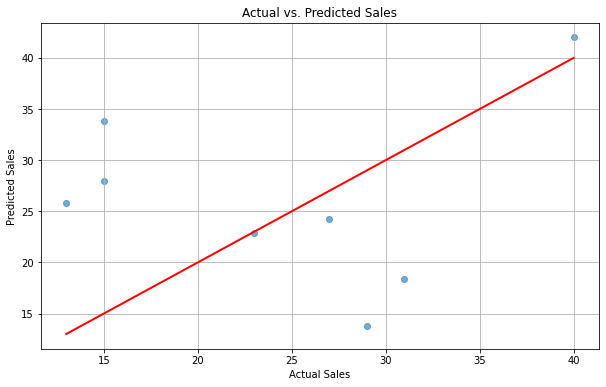

In [0]:
import matplotlib.pyplot as plt
predictions_pd = predictions.select("Sales", "prediction").toPandas()
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["Sales"], predictions_pd["prediction"], alpha=0.6)
plt.plot([predictions_pd["Sales"].min(), predictions_pd["Sales"].max()],
         [predictions_pd["Sales"].min(), predictions_pd["Sales"].max()], color='red', lw=2)
plt.title('Actual vs. Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.grid()
plt.show()